In [8]:
import argparse
import torch
import numpy as np
import wandb
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Unet1D, GaussianDiffusion1D
from unnormalized_densities import Toy_dataset
from torch.utils.data import DataLoader
from tqdm import trange
from probability_flow_ode import ProbabilityFlowODE


from net import MLP, UnclippedDiffusion

/home/sujin/anaconda3/envs/toy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

datanum = 50000
num_epochs = 1000
output_file = 'images/sampled_images.png'
model_save_path = 'models/trained_model.pth'
distribution = 'checkerboard'



train_batch_size = 100
sample_batch_size = 100
num_inner_epochs = 1

In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model setup
model = MLP()

diffusion = UnclippedDiffusion(
    model=model,
    seq_length=2,
    timesteps=100,
    auto_normalize=False,
)

model = model.to(device)
diffusion = diffusion.to(device)

state_dict = torch.load(f"models/{distribution}/save_model.pt")
diffusion.load_state_dict(state_dict)


/tmp/ipykernel_144502/4150609115.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"models/{distribution}/save_model.pt")


<All keys matched successfully>

In [9]:
latents, logprobs, img = diffusion.ddim_sample_with_logprob(batch_size=int(datanum/10), sampling_timesteps=100)  # Shape: (1000, 2)

sampling loop time step: 100%|██████████| 100/100 [00:00<00:00, 643.52it/s]


In [19]:
img.shape

torch.Size([5000, 1, 2])

In [17]:
ts, tp = diffusion.prepare_ddim_timesteps(100)

In [18]:
torch.tensor(ts).repeat(1000, 1).shape

torch.Size([1000, 101])

In [7]:
ts

[99,
 98,
 97,
 96,
 95,
 94,
 93,
 92,
 91,
 90,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 -1]

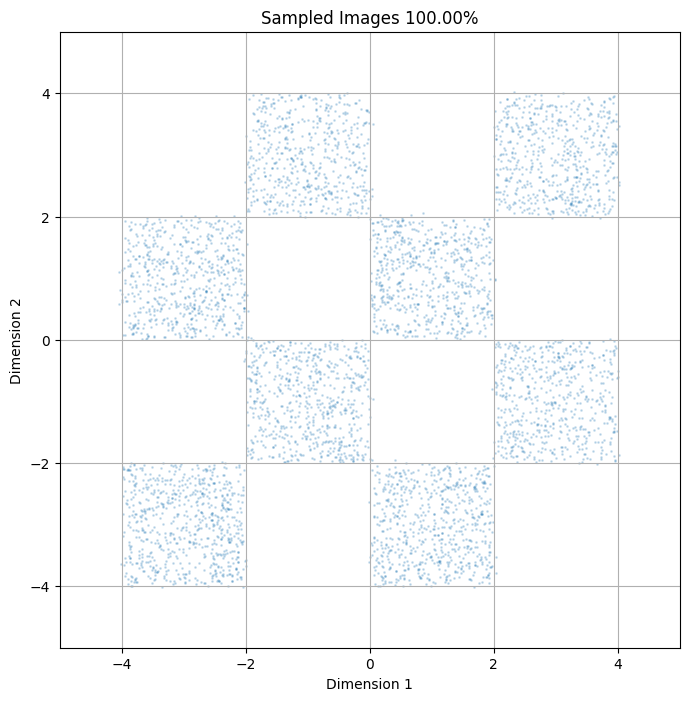

In [5]:

sampled_images = latents[-1].squeeze(1).cpu().detach().numpy()  # Shape: (1000, 2)
within_bounds = np.all((sampled_images >= -5) & (sampled_images <= 5), axis=1)
proportion_within_bounds = np.mean(within_bounds)

plt.figure(figsize=(8, 8))
plt.scatter(sampled_images[:, 0], sampled_images[:, 1], alpha=0.2, s=1)
plt.title(f"Sampled Images {proportion_within_bounds * 100:.2f}%")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.grid(True)


plt.show()

In [10]:
latents[0].shape

torch.Size([5000, 1, 2])

In [11]:
logprobs[0].shape

torch.Size([5000])

In [12]:
len(logprobs)

99

In [15]:
# einops for switching dimensions
lat = torch.stack(logprobs, dim = 1)
print(lat.shape)

torch.Size([5000, 99])


In [5]:
densities = np.exp(gmm.score_samples(XY))
densities

array([3.25201407e-16, 6.29849660e-16, 1.19698530e-15, ...,
       5.52245584e-14, 3.02323875e-14, 1.64907970e-14])

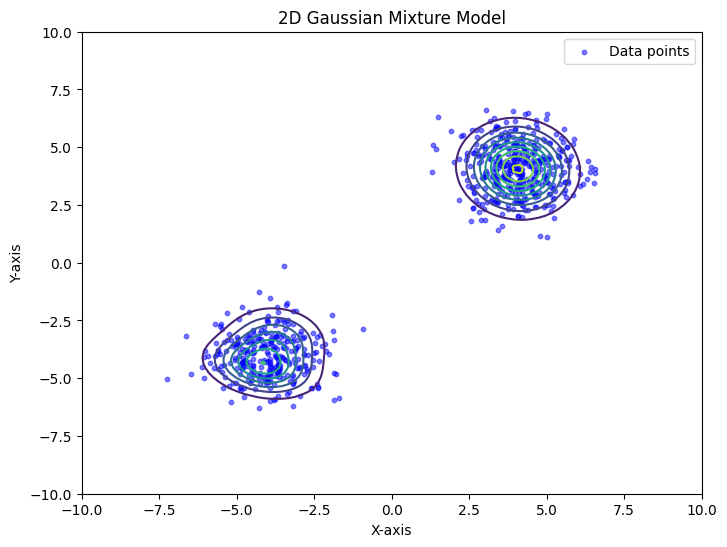

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 가우시안 혼합 모델 설정
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
np.random.seed(42)
            data1 = np.random.randn(300, 2) * 2 - 4      # 원래 데이터 (평균 대략 (0,0))
            data2 = np.random.randn(300, 2) * 2 + 4          # (4,4) 부근 데이터 (평균 대략 (4,4))

data = np.vstack([data1, data2])   
gmm.fit(data)

# 밀도 계산을 위한 grid 생성
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])

# 밀도 계산
densities = np.exp(gmm.score_samples(XY))
Z = densities.reshape(100, 100)

# 시각화
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=10, cmap='viridis')
plt.scatter(data[:, 0], data[:, 1], c='blue', s=10, alpha=0.5, label='Data points')
plt.title("2D Gaussian Mixture Model")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.show()

In [22]:
np.exp(gmm.score_samples(np.array([[4,4]])))

array([0.09144145])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = MLP()

diffusion = UnclippedDiffusion(
    model=model,
    seq_length=2,
    timesteps=500,
    auto_normalize=False,
)

model = model.to(device)
diffusion = diffusion.to(device)
# Dataset and DataLoader
custom = Toy_dataset("elliptic_paraboloid", minimum=0, datanum=50000, device=device)
dataloader = DataLoader(custom, batch_size=1024, shuffle=True)

# Optimizer
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)

# Training loop
for epoch in trange(2):
    epoch_loss = 0
    batch_count = 0
    for batch in dataloader:
        training_data = batch[:, None, :]  # Extract the training data
        print(training_data.shape)

 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]

torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([848, 1, 2])
